In [1]:
import tensorflow as tf
import numpy as np

In [2]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10


In [3]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")


In [4]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_neurons)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z


Instead of our *neuron_layer* function, we could have used *tf.layers.dense*

In [5]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")


Loss definition

In [6]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")


In [7]:
learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [8]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [9]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [10]:

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]



In [11]:
n_epochs = 40
batch_size = 50

In [12]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [13]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "saved_models/my_model_final.ckpt")

0 Batch accuracy: 0.92 Val accuracy: 0.9118


1 Batch accuracy: 0.9 Val accuracy: 0.9312


2 Batch accuracy: 0.96 Val accuracy: 0.9396


3 Batch accuracy: 1.0 Val accuracy: 0.9462


4 Batch accuracy: 0.98 Val accuracy: 0.9492


5 Batch accuracy: 0.98 Val accuracy: 0.956


6 Batch accuracy: 0.96 Val accuracy: 0.9572


7 Batch accuracy: 0.96 Val accuracy: 0.9598


8 Batch accuracy: 1.0 Val accuracy: 0.9636


9 Batch accuracy: 0.98 Val accuracy: 0.9662


10 Batch accuracy: 0.98 Val accuracy: 0.969


11 Batch accuracy: 0.96 Val accuracy: 0.97


12 Batch accuracy: 0.96 Val accuracy: 0.9692


13 Batch accuracy: 1.0 Val accuracy: 0.9692


14 Batch accuracy: 0.96 Val accuracy: 0.971


15 Batch accuracy: 0.98 Val accuracy: 0.9714


16 Batch accuracy: 0.98 Val accuracy: 0.9714


17 Batch accuracy: 1.0 Val accuracy: 0.9732


18 Batch accuracy: 0.98 Val accuracy: 0.9728


19 Batch accuracy: 1.0 Val accuracy: 0.9754


20 Batch accuracy: 0.96 Val accuracy: 0.9744


21 Batch accuracy: 0.96 Val accuracy: 0.974


22 Batch accuracy: 1.0 Val accuracy: 0.9748


23 Batch accuracy: 1.0 Val accuracy: 0.9744


24 Batch accuracy: 0.98 Val accuracy: 0.9742


25 Batch accuracy: 1.0 Val accuracy: 0.976


26 Batch accuracy: 0.96 Val accuracy: 0.9756


27 Batch accuracy: 0.98 Val accuracy: 0.9762


28 Batch accuracy: 0.98 Val accuracy: 0.9772


29 Batch accuracy: 1.0 Val accuracy: 0.9768


30 Batch accuracy: 0.98 Val accuracy: 0.9768


31 Batch accuracy: 1.0 Val accuracy: 0.9768


32 Batch accuracy: 1.0 Val accuracy: 0.9774


33 Batch accuracy: 0.98 Val accuracy: 0.976


34 Batch accuracy: 1.0 Val accuracy: 0.977


35 Batch accuracy: 1.0 Val accuracy: 0.9788


36 Batch accuracy: 1.0 Val accuracy: 0.9776


37 Batch accuracy: 1.0 Val accuracy: 0.9772


38 Batch accuracy: 1.0 Val accuracy: 0.9776


39 Batch accuracy: 1.0 Val accuracy: 0.9778


In [15]:
with tf.Session() as sess:
    saver.restore(sess, "saved_models/my_model_final.ckpt")  # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)


INFO:tensorflow:Restoring parameters from saved_models/my_model_final.ckpt


In [33]:
print("Predicted classes:", y_pred)
print("Actual classes:      ", y_test[:20])

Predicted classes: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:       [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt


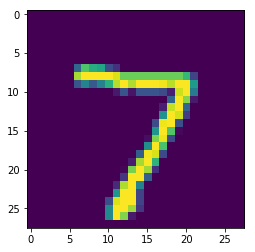

Predicted class: 7
Actual class:    7


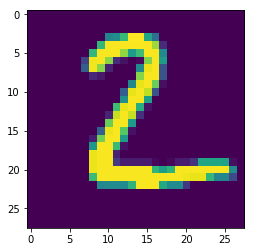

Predicted class: 2
Actual class:    2


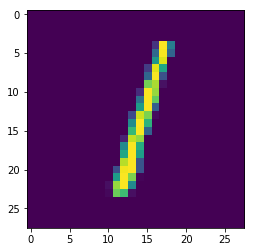

Predicted class: 1
Actual class:    1


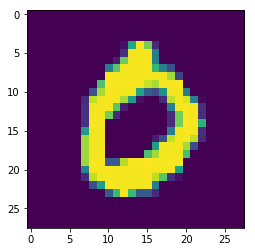

Predicted class: 0
Actual class:    0


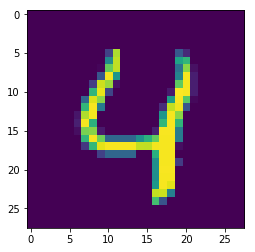

Predicted class: 4
Actual class:    4


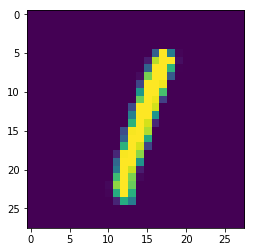

Predicted class: 1
Actual class:    1


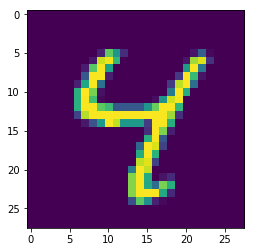

Predicted class: 4
Actual class:    4


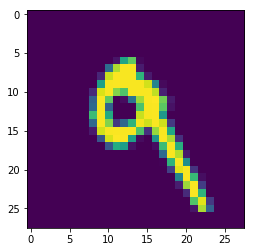

Predicted class: 9
Actual class:    9


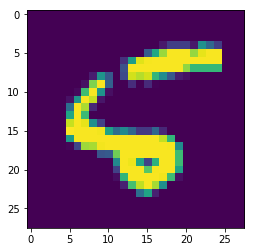

Predicted class: 6
Actual class:    5


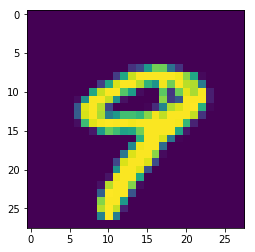

Predicted class: 9
Actual class:    9


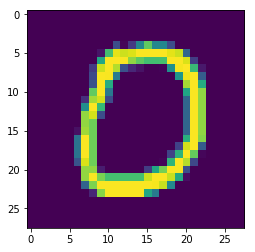

Predicted class: 0
Actual class:    0


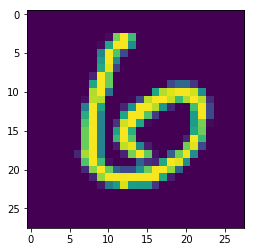

Predicted class: 6
Actual class:    6


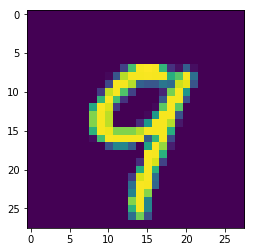

Predicted class: 9
Actual class:    9


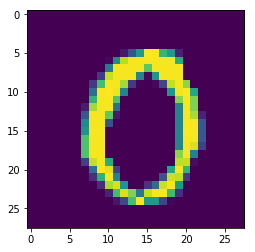

Predicted class: 0
Actual class:    0


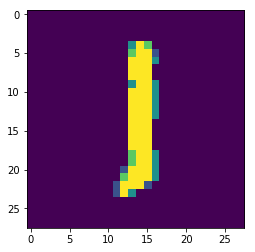

Predicted class: 1
Actual class:    1


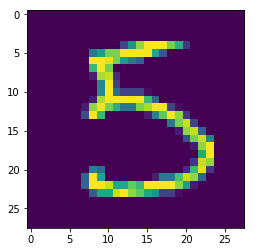

Predicted class: 5
Actual class:    5


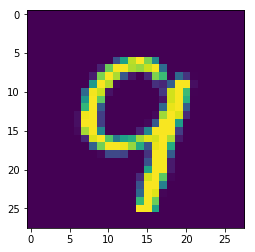

Predicted class: 9
Actual class:    9


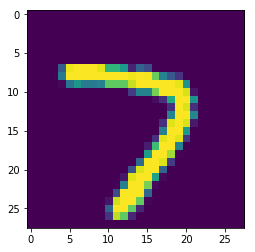

Predicted class: 7
Actual class:    7


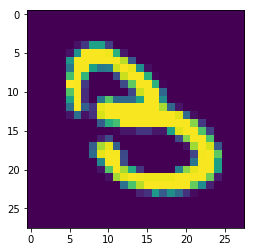

Predicted class: 3
Actual class:    3


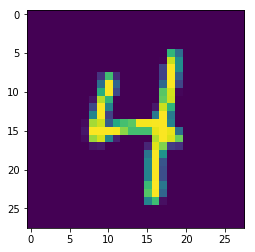

Predicted class: 4
Actual class:    4


In [34]:
for index in range(len(y_pred)):
    plt.imshow(np.reshape(X_test[index], (28, 28)))
    plt.show()
    print("Predicted class:", y_pred[index])
    print("Actual class:   ", y_test[index])